In [1]:
from qibo.backends import construct_backend
from qibo import hamiltonians, Circuit, gates, set_backend
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from copy import deepcopy
from qibo.symbols import X, Y, Z

import numpy as np
import matplotlib.pyplot as plt
from qibo import gates, symbols
from qibo import hamiltonians
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian

from boostvqe.models.dbqa.group_commutator_iteration import GroupCommutatorIteration, DoubleBracketRotationApproximationType
from boostvqe.models.dbqa.evolution_oracles_CZ_gates import EvolutionOracle, EvolutionOracleType
from boostvqe.models.dbqa.double_bracket_iteration import DoubleBracketIteration

from copy import deepcopy

/home/marek/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Initializing circuit

In [2]:
# import initialization
L = 16
delta = 1
nlayers = 1
H = hamiltonians.SymbolicHamiltonian(
    sum([X(i)*X(i+1)+ Y(i)*Y(i+1) + delta* Z(i)*Z(i+1) for i in range(L-1)]))
psi0 = np.zeros(2**L)
psi0[0] = 1
file_path = f"results/circuit_qasm/cobyla_{L}q_{nlayers}l_XXZ/hva_circ.qasm"
with open(file_path, 'r') as file:
            circ_str = file.read()
init_circ = Circuit.from_qasm(circ_str)
c = Circuit(L)
init_circ.init_kwargs = c.init_kwargs #temporary fix for init_kwargs
def h_expectation_from_circ(ham, circ):
    # calculates the exact expectation of hamiltonian given a circuit in qibo
    return ham.expectation(
        ham.backend.execute_circuit(circuit=circ).state())
print(h_expectation_from_circ(H, init_circ))

[Qibo 0.2.21|INFO|2025-07-29 17:55:59]: Using qibojit (numba) backend on /CPU:0


-26.978755907262773


In [13]:
B_i = [1]*L
magnetic_hamiltonian = hamiltonians.SymbolicHamiltonian(
    sum([B_i[i] * Z(i) for i in range(L)]))

diagonal_evolution_oracle = EvolutionOracle(
    h=magnetic_hamiltonian,
    evolution_oracle_type=EvolutionOracleType.hamiltonian_simulation
)

hamiltonian_evolution_oracle = EvolutionOracle(
    h=H,
    evolution_oracle_type=EvolutionOracleType.hamiltonian_simulation
)
from boostvqe.models.dbqa.evolution_oracles_CZ_gates import FrameShiftedEvolutionOracle
frame_shifted_eo = FrameShiftedEvolutionOracle.from_evolution_oracle(
    base_evolution_oracle=hamiltonian_evolution_oracle,
    before_circuit=init_circ.invert(),
    after_circuit=init_circ
)

In [17]:
gci_hva = GroupCommutatorIteration(
    input_hamiltonian_evolution_oracle=frame_shifted_eo,
    double_bracket_rotation_type=DoubleBracketRotationApproximationType.group_commutator_reduced)

In [18]:
gci_hva.loss()

np.float64(-26.978755907262773)

In [19]:
gci_hva.loss(None, diagonal_evolution_oracle, mode_dbr=gci_hva.double_bracket_rotation_type )

np.float64(-26.978755907262773)

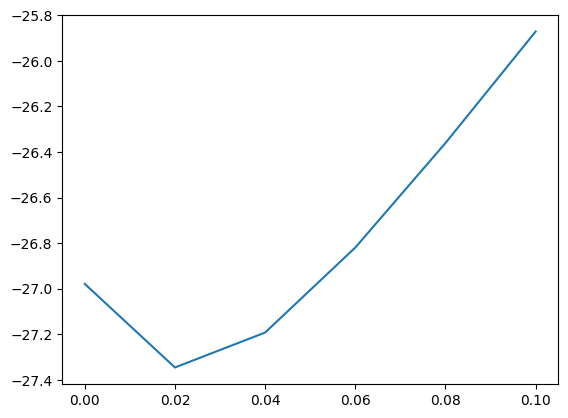

In [21]:
a = [ gci_hva.loss(t, diagonal_evolution_oracle ) 
 for t in np.linspace(0, .1, 6) ]
plt.plot(np.linspace(0, .1, 6), a)

## Hamiltonian simulation

$$e^{-itH} \approx e^{-itH_0}e^{-itH_1}\approx e^{-it/2H_0}e^{-itH_1}e^{-it/2H_0}$$

In Qibo, `RZZ(q0, q1, theta)`$=e^{-i\frac{\theta}{2}ZZ}$

In [ ]:
# check rxx formula
t = 0.5
qc = Circuit(2)
qc.add(gates.RXX(0, 1, t*2))
x = np.array([[0,1], [1,0]])
xx = np.kron(x, x)
u = sp.linalg.expm(-1j*t*xx)
print(np.linalg.norm(u-qc.unitary())<1e-11)

True


In [ ]:
def XXZ_simulation(nqubits, delta, t, trotter_steps=2, boundary="open", layer=3):
    qc = Circuit(nqubits)
    even_pairs = [(i, i+1) for i in range(0, nqubits-1, 2)]
    odd_pairs = [(i, i+1) for i in range(1, nqubits-1, 2)]
    if boundary == 'closed':
        odd_pairs.append((0, nqubits-1))
        
    dt_even = t/trotter_steps*2
    dt_odd = t/trotter_steps*2
    if layer == 3:
        dt_even /= 2
        
    for _ in range(trotter_steps):
        for i,j in even_pairs:
            qc.add(gates.RXX(i, j, dt_even))
            qc.add(gates.RYY(i, j, dt_even))
            qc.add(gates.RZZ(i, j, dt_even*delta))
        for i, j in odd_pairs:
            qc.add(gates.RXX(i, j, dt_odd))
            qc.add(gates.RYY(i, j, dt_odd))
            qc.add(gates.RZZ(i, j, dt_odd*delta))
        if layer == 3:
            for i,j in even_pairs:
                qc.add(gates.RXX(i, j, dt_even))
                qc.add(gates.RYY(i, j, dt_even))
                qc.add(gates.RZZ(i, j, dt_even*delta))
                
    return qc

In [ ]:
# check hamiltonian simulation
L_test = 6
delta_test = 0.5
boundary_test = 'open'
H_test = construct_XXZ(L_test, delta_test, boundary_test)
t = 0.2
print(np.linalg.norm(sp.linalg.expm(-1j*t*H_test.matrix) - XXZ_simulation(L_test, delta_test, t, layer=3).unitary()))

[Qibo 0.2.21|WARNING|2025-07-29 15:37:49]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0.03903661129144955


## Magnetic field

RZ in qibo: $e^{-i\frac{\theta}{2}D}$

In [ ]:
# magnetic field
def magnetic_field_circ(coefs, t):
    # implments e^{-itD}
    nqubits = len(coefs)
    qc = Circuit(nqubits)
    
    for idx, coef in enumerate(coefs):
        qc.add(gates.RZ(idx, coef*t*2))
    return qc 

In [ ]:
# test d formula
theta = 0.5
d = magnetic_field_circ([1], theta)
d_u = sp.linalg.expm(-1j*theta*np.array([[1,0],[0,-1]]))
print(np.linalg.norm(d.unitary()-d_u)<1e-3)

True


## Construct GCI circuit
In the initialization step, we have
$$
\bra{\psi_0(\theta)} H\ket{\psi_0(\theta)}=\bra{0}U_\theta^\dagger H U_\theta\ket{0}=\bra{0}A_0\ket{0}
$$
For one step of DBQA, 
$$
V_1 = e^{itD}U^\dagger e^{-itH_0}Ue^{-itD}
$$
and that
$$
A_1 = V_1^\dagger U^\dagger H_0 U V_1.
$$

With this we find
$$
\langle 0|A_1|0\rangle =\langle \psi_1|H|\psi_1\rangle = \bra 0 U_1^\dagger H U_1\ket 0
$$
where 
$$
|\psi_1\rangle = U* V_1|0\rangle.
$$

Therefore, our composed DBQA circuit should follow

$$
U_1 = U*V_1 = U_\theta e^{itD}U_\theta ^\dagger e^{-itH}U_\theta e^{-itD}
$$

$$
U_1^{(RHOPF)} = U \cdot V_1^{(RHOPF)}=Ue^{-i\phi \sqrt t D}U^\dagger e^{-i\sqrt tH} U
            e^{i(\phi+1)\sqrt t D}U^\dagger e^{i(1-\phi)\sqrt tH} U e^{-i\phi \sqrt t D}.
$$

In [ ]:
def GCI(H, H_sim_fun, D_circ_fun, init_circ, t):
    qc = Circuit(H.nqubits)
    H_sim = H_sim_fun(t)
    D_circ = D_circ_fun(t)
    qc.wire_names = init_circ.wire_names
    D_circ.wire_names = qc.wire_names
    H_sim.wire_names = qc.wire_names
    qc = qc + D_circ + init_circ + H_sim + init_circ.invert() + D_circ.invert() + init_circ
    return qc, h_expectation_from_circ(H, qc)

In [ ]:
# test t=0 same value as E_init
t = 0
coefs = [1] * L
H_sim_fun = lambda t: XXZ_simulation(L, delta, t)
D_circ_fun = lambda t: magnetic_field_circ(coefs, t)
gci_circ, gci_val = GCI(H, H_sim_fun, D_circ_fun, init_circ, t)
print(np.abs(gci_val-h_expectation_from_circ(H, init_circ))<1e-3)

NameError: name 'h_expectation_from_circ' is not defined

In [ ]:
run_grid_search = False
if run_grid_search:
    t_space = np.linspace(0,0.3,20)
    E_ls = []
    for t in t_space:
        gci_circ, gci_val = GCI(H, H_sim_fun, D_circ_fun, init_circ, t)
        E_ls.append(gci_val)

In [ ]:
if run_grid_search:
    E_min = min(E_ls)
    min_idx = E_ls.index(E_min)
    t_min = t_space[min_idx]
    plt.plot(t_space, E_ls)
    plt.scatter(t_min, E_min, color='red', label=f"({t_min:.2f}, {E_min:.2f})")
    plt.title(f'DBQA gain with time - XXZ (L={L})')
    plt.xlabel('time')
    plt.ylabel(r'$\langle H\rangle$')
    plt.legend()

In [ ]:
gci_circ.gate_names

Counter({'h': 384,
         'rzz': 181,
         'sdg': 90,
         's': 90,
         'x': 48,
         'rxx': 46,
         'ryy': 46,
         'rz': 32,
         'cx': 24})

In [ ]:
print("Circuit depth:", gci_circ.depth)
print("Circuit total gate count:", gci_circ.ngates)
print("Circuit CX count:", gci_circ.gate_names['cx'])
print("Estimated equivalent CZ count:", gci_circ.gate_names['cx']+
      gci_circ.gate_names['rxx']+gci_circ.gate_names['ryy']+gci_circ.gate_names['rzz']
      )

Circuit depth: 83
Circuit total gate count: 941
Circuit CX count: 24
Circuit CZ count: 297


## Optimize parameters

### Fixed D optimize t

Here we expect the same value as the grid search but faster run time.

In [ ]:
from scipy.optimize import minimize_scalar
coefs = [1] * L
def objective(t):
    H_sim_fun = lambda t: XXZ_simulation(L, delta, t)
    D_circ_fun = lambda t: magnetic_field_circ(coefs, t)
    gci_circ, gci_val = GCI(H, H_sim_fun, D_circ_fun, init_circ, t)
    return gci_val

In [ ]:
res = minimize_scalar(
    objective,                  
    method='brent',    
    options={'maxiter': 15,
             'xtol': 1e-3} 
)
print(res.fun)
print(res.x)

-27.327291516178352
0.14351650971963992


### Optimize both D and t

In [ ]:
from scipy.optimize import minimize
coefs = [1] * L
D_s = coefs + [0.1]
def objective(D_s):
    coefs = D_s[:-1]
    t = D_s[-1]
    H_sim_fun = lambda t: XXZ_simulation(L, delta, t)
    D_circ_fun = lambda t: magnetic_field_circ(coefs, t)
    gci_circ, gci_val = GCI(H, H_sim_fun, D_circ_fun, init_circ, t)
    return gci_val

In [ ]:
max_iter = 1000
result = minimize(
    objective,
    D_s,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 111   Least value of F = -27.306620269782684
The corresponding X is:
[1.94500013 1.94499979 1.94500054 1.94500004 1.94500005 1.94500031
 1.94500042 1.94499978 1.94500016 1.94499983 1.94500002 1.94500011
 1.99499996 1.00499996 1.9949998  1.98250001 0.09964276]

-27.306620269782684
[1.94500013 1.94499979 1.94500054 1.94500004 1.94500005 1.94500031
 1.94500042 1.94499978 1.94500016 1.94499983 1.94500002 1.94500011
 1.99499996 1.00499996 1.9949998  1.98250001 0.09964276]
